In [1]:
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchsummary import summary

from model import VariationalAutoEncoder
from train import train_fn

In [2]:
# Hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
RANDOM_SEED = 42

BATCH_SIZE = 64
IMAGE_SIZE = 28
IMAGE_CHANNELS = 1
NUM_WORKERS = 2

In [3]:
transform = transforms.Compose(
    [   
        transforms.ToTensor(),
    ]
)

In [4]:
dataset = torchvision.datasets.MNIST(
    root="./data",
    transform=transform,
    download=True)

dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

In [5]:
class_names = dataset.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

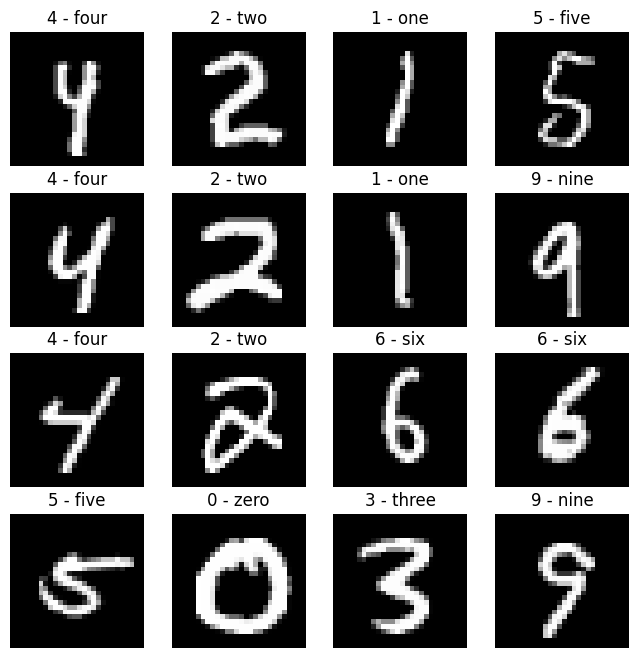

In [6]:
fig = plt.figure(figsize = (8, 8))
rows, cols = 4, 4

for i in range(1, rows*cols + 1):
  idx = torch.randint(0, len(dataset), size = [1]).item()
  img, idx = dataset[idx]

  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap = "gray")
  plt.title(class_names[idx])
  plt.axis(False);

In [8]:
def log_categorical(x, mu_x, num_classes):
  """
  """
  # Reshaping process
  x = x.view(x.shape[0], x.shape[2] ** 2)

  # Image one hot encoding
  x_one_hot = F.one_hot(x.long(), num_classes=num_classes)
  log_p = x_one_hot * torch.log(torch.clamp(mu_x, 1.e-5, 1.0 - 1.e-5))

  return torch.sum(log_p, -1)


def reconstruction_error(x_real, mu_x, num_classes):
  """
  This function compute the reconstruction loss between real images and predicted parameters.
  """
  error = log_categorical(
      x=x_real,
      mu_x=mu_x,
      num_classes=num_classes).sum(-1) / x_real.size(0)

  return error 


def kullback_leibler_divergence(mu1, log_var1, mu2, log_var2):
  """
  This function compute the Kullback-Leibler divergence between two gaussians.
  """
  return (log_var2 - log_var1 + (torch.exp(log_var1) + (mu1 - mu2) ** 2) / torch.exp(log_var2) - 1) / 2


def kl_loss(mu_z, log_var_z, device):
  """
  This function compute Kullback_Leibler divergence between N(z; mu_z, sigma_z^2) and N(0, 1)
  """
  kl_divergence = kullback_leibler_divergence(
      mu1=mu_z,
      log_var1=log_var_z,
      mu2=torch.zeros(size=(1,), device=device),
      log_var2=torch.zeros(size=(1,), device=device)).sum()

  return kl_divergence / mu_z.size(0)

In [9]:
def ELBO(x, mu_z, log_var_z, mu_x, num_classes=256, beta=1, device="cuda"):
  """
  This function computes the lower bound on the log-likelihood of data, called Evidence Lower Bound Optimization (ELBO).
  The variables mu_z and log_var_z come from encoder, while the variable mu_x comes from decoder.
  """
  RE = reconstruction_error(
      x_real=x,
      mu_x=mu_x,
      num_classes=num_classes)

  KL = kl_loss(
      mu_z=mu_z,
      log_var_z=log_var_z,
      device=device)
  
  return (-RE + beta * KL).sum()

In [10]:
# Hyperparameters
L = 16  # number of latents
NUM_VALS = 256 # the number of how many values a pixel can take

LEARNING_RATE = 1e-3 # learning rate
NUM_EPOCHS = 3 # max. number of epochs

BETA = 100000. # regularization coefficient for Kullback–Leibler divergence

In [11]:
encoder = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    
    nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(num_features=16),
    nn.ReLU(),

    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
    nn.ReLU(),

    nn.Flatten(),
    nn.Linear(in_features=32 * 3 * 3, out_features=256),
    nn.ReLU(),
    
    nn.Linear(in_features=256, out_features=2 * L)
)

decoder = nn.Sequential(
        nn.Linear(in_features=L, out_features=128),
        nn.ReLU(inplace=True),

        nn.Linear(in_features=128, out_features=32 * 3 * 3),
        nn.ReLU(inplace=True),

        nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),

        nn.ConvTranspose2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, output_padding=0),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),

        nn.ConvTranspose2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
)

In [12]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)


model = VariationalAutoEncoder(
    encoder_network=encoder,
    decoder_network=decoder,
    num_vals=NUM_VALS
).to(DEVICE)

#summary(model)

In [13]:
optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)

Epoch: 0 / 10
-------


100%|██████████| 938/938 [00:20<00:00, 44.91it/s]

Train loss: 1555.9233



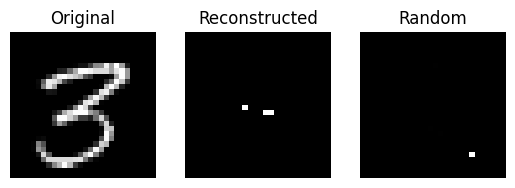

Epoch: 1 / 10
-------


100%|██████████| 938/938 [00:18<00:00, 51.82it/s]

Train loss: 36.3019



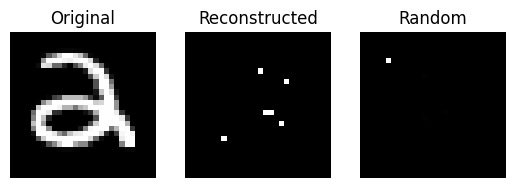

Epoch: 2 / 10
-------


100%|██████████| 938/938 [00:17<00:00, 52.12it/s]

Train loss: 32.7702



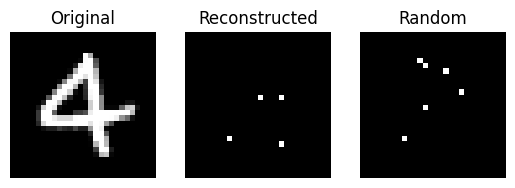

Epoch: 3 / 10
-------


100%|██████████| 938/938 [00:17<00:00, 52.16it/s]

Train loss: 32.3703



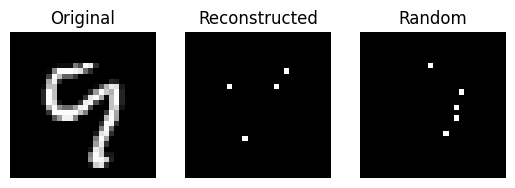

Epoch: 4 / 10
-------


100%|██████████| 938/938 [00:17<00:00, 52.49it/s]

Train loss: 32.2256



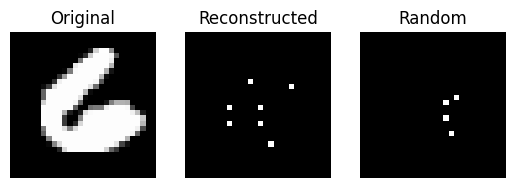

Epoch: 5 / 10
-------


100%|██████████| 938/938 [00:18<00:00, 51.54it/s]

Train loss: 32.2917



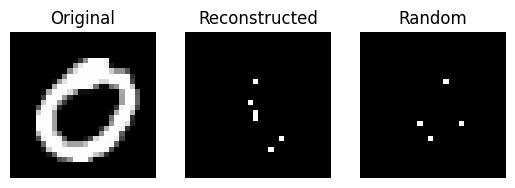

Epoch: 6 / 10
-------


100%|██████████| 938/938 [00:18<00:00, 50.69it/s]

Train loss: 32.5125



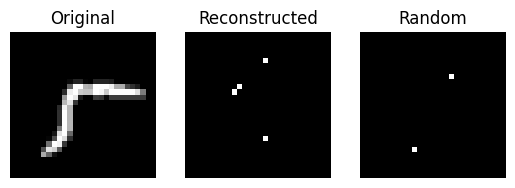

Epoch: 7 / 10
-------


100%|██████████| 938/938 [00:18<00:00, 51.99it/s]

Train loss: 32.5543



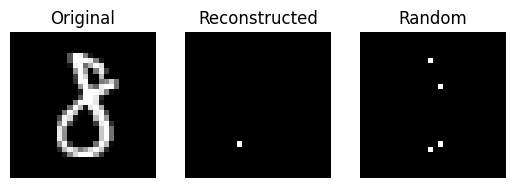

Epoch: 8 / 10
-------


100%|██████████| 938/938 [00:18<00:00, 51.86it/s]

Train loss: 32.6496



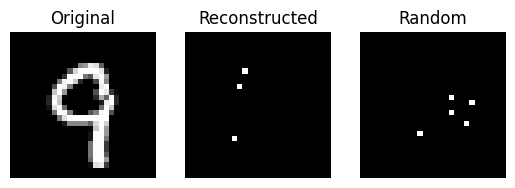

Epoch: 9 / 10
-------


100%|██████████| 938/938 [00:18<00:00, 51.68it/s]

Train loss: 32.5536



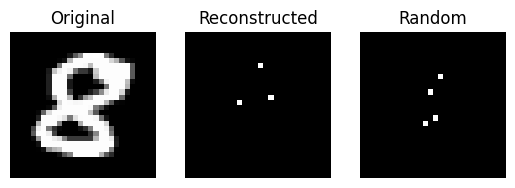

=> Saving checkpoint


In [14]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

NUM_EPOCHS = 10

loss_history, learning_rates, store = train_fn(
    model,
    dataloader,
    optimizer,
    ELBO,
    beta = BETA,
    num_epochs=NUM_EPOCHS,
    device=DEVICE)